In [1]:
import numpy as np
import math
import scipy.special as ss
from scipy.optimize import minimize_scalar

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def CP(Y, tol):

    """
    INITIALIZATION
    Y - input tensor (complete)
    tol - lower band change tolerance for convergence dection
    init = ml - Apply SVD to Y and initialize factor matrices

    maxiters - maximum number of iterations
    """

    """
    OUTPUT
    LB_res - lower bounds on each iterations
    """

    init = 'ml'
    dimY = np.shape(Y)
    N = len(dimY)
    nObs = np.prod(dimY)
    maxiters = 100
  #  tol = 1e-4
    LB_res = []
    conv_res =  []
    
    X_true = np.array([])
    R = max(dimY)
    
    a_gamma0     = 1e-6
    b_gamma0     = 1e-6
    a_beta0      = 1e-6
    b_beta0      = 1e-6
    a_alpha0     = 1e-6
    b_alpha0    = 1e-6

    eps = 1e-18
    initVar = 1
    LB = [0]
    
    gammas = (a_gamma0+eps)/(b_gamma0+eps)*np.ones((R,1))
  #  print(gammas)
    beta = (a_beta0+eps)/(b_beta0+eps)
    alphas = 1 / initVar *np.ones(dimY)*((a_alpha0+eps)/(b_alpha0+eps))
    #print(alphas)
    
    
    E = 1 / np.sqrt(alphas)*np.random.randn(*dimY)
  
    Sigma_E = 1/alphas * np.ones(dimY)
    
    
    """
    Apply SVD to Y and initialize factor matrices
    """
    if init == 'ml':
       
        Z = [0]
        ZSigma = [0]
        for n in range(N):
        #i = 0
        #for n in dimY:
            if n == 0:
            #if i == 0:
                ZSigma[0] = np.diag(1/gammas)
               # rest = nObs / dimY[n] #/ dimY[n+1]
               # dim = dimY[n+1]
            else:
                ZSigma.append(np.diag(1/gammas))
                
               # dim = dimY[n-1]
           # print(type(Y[n]), type(dim), type(rest))
            rest = nObs / dimY[n] 
            U, S, V = np.linalg.svd(np.swapaxes(Y, n, 0).reshape(dimY[n], int(rest)))
            #print(U, S)
            #print(U.shape, S.shape, V.shape)
            #S = S.reshape(len(S), 1)
            S = np.diag(S)
            dvar = np.sqrt(np.sum(Y ** 2)/ nObs)
            
           # print(U, S, V)
            if R <= U.shape[1]:
                if n == 0:
                   # print(U.shape, S.shape)
                    #print(U[:,:R].shape, S[:R, :R].shape)
                    Z[0] = U[:,:R] @ np.sqrt(S[:R,:R])
                else:
                    Z.append(U[:,:R] @ np.sqrt(S[:R,:R]))
                #print(0)
                
                    
            else:
                if n == 0:
                    #Z[0] = [U@np.sqrt(np.diag(S)), np.random.randn(dimY[n],R - U.shape[1]) * dvar]
                    Z[0] = np.hstack((U@np.sqrt(S), np.random.randn(dimY[n],R - U.shape[1]) * dvar))
                    #Z[0] = U@np.sqrt(S)
                else:
                    #Z.append([U@np.sqrt(np.diag(S)), np.random.randn(dimY[n],R - U.shape[1]) * dvar])
                 #   print(U@np.sqrt(S))
                   # print(np.ravel(np.random.randn(dimY[n],R - U.shape[1]) * dvar))
                   # print(U@np.sqrt(S))
                    Z.append(np.hstack((U@np.sqrt(S), np.random.randn(dimY[n],R - U.shape[1]) * dvar)))
                    #Z.append(U@np.sqrt(S))
         #   print(Z[n])
                    
   # print(ZSigma)
  #  print(Z)
    
    """
    Model learning
    """
    EZZT = [0]
    
   # print(np.array(ZSigma))
    #ZSigma = np.array(ZSigma)
    #print(Z, dimY, ZSigma)
  #  for i in range(len(Z)):
   #     Z[i] = np.array(Z[i])
  #  print(Z)
    #Z = np.array(Z)
 #   print(Z.shape, np.array(ZSigma).shape)
    EZZT[0] = np.array(Z[0]).T @ np.array(Z[0]) + dimY[0] * np.array(ZSigma)[0]
    for n in range(1,N):
        EZZT.append(Z[0].T @ Z[0] + dimY[0] * np.array(ZSigma)[0])
        
    for i in range(maxiters):
        """
        Update factor matrices
        """
        Aw = np.diag(gammas)
        for n in range(N):
            """
            compute E(Z_{\n}^{T} Z_{\n})
            """
            ENZZT = np.ones((R,R))
            for m in range(N):
                if m != n:
                    ENZZT = ENZZT * EZZT[m]
            """
            compute E(Z_{\n})*(Y-E)
            khatri-rao product
            """
            orig = np.linspace(0,N-1,N,dtype=int)
            #print(orig)
            inds = np.delete(orig, n)
            inds = np.flip(inds)
            #print(Z, len(Z))
           # print(inds)
            if n != (N-1):
                A = Z[N-1]
            else:
                A = Z[N-2]
            inds = np.delete(inds, 0)    
            #print(A)
            
            sh = A.shape[1]
           # print(Z)
          #  print(Z.shape)
        #    print(inds)
            for j in inds:
               # print(Z.shape)
                #print(inds[j])
                
                    
                B = Z[j]
                for col in range(sh):
                    kron_col = np.kron(A[:,col],B[:,col])
                    kron_col = kron_col[np.newaxis, :].T
                    if col > 0:
                        khatri = np.hstack((khatri, kron_col))
                    else:
                        khatri = kron_col
                  #  print(khatri)
                A = khatri
               # print(A)
            
            rest = nObs / dimY[n]
            tenmat = np.swapaxes(Y-E,int(n),0).reshape(int(dimY[n]), int(rest))
         #   print(A.shape, tenmat.shape)
            FslashY = A.T @ tenmat.T
          #  print(tenmat.shape)
            """
            compute posterior distribution
            """
            ZSigma[n] = np.linalg.inv(beta * ENZZT + Aw)
            #print(ZSigma[n])
            
          #  print(np.array(ZSigma)[n].shape, FslashY.shape)
            Z[n] = (beta * np.array(ZSigma)[n] @ FslashY).T
            EZZT[n] = Z[n].T @ Z[n] + dimY[n] * ZSigma[n]
          #  print(Z[n])
            
        
        #print(np.array(Z))
        """
        reshape / cut / add zeros
        """
        X = Z[0]
    #    print(X)
        for j in range(1,len(Z)):
     #       print(Z[j])
            X = np.vstack((X,Z[j]))
       # X = X.reshape(*dimY)
        X = np.ravel(X)
      #  np.random.shuffle(X)
        X = X[:nObs]
       # np.random.shuffle(np.ravel(X))[:nObs]
        #print(Z)
        #print(nObs)
        try:
            X = X.reshape(*dimY)
          #  print('Yes')
        except ValueError:
            X = np.ravel(X)
          #  add = np.random.randn(nObs-len(X))
            add = np.zeros(nObs-len(X))
            X = np.hstack((X, add))
            X = X.reshape(*dimY)
      #  X = np.array(Z).reshape(*dimY)
    
        """
        Update hyperparameters gamma
        """
        
        a_gammaN = (0.5 * np.sum(dimY) + a_gamma0) * np.ones((R,1))
        b_gammaN = 0
        for n in range(N):
            b_gammaN = b_gammaN + np.diag(Z[n].T @ Z[n]) + dimY[n] * np.diag(ZSigma[n])
        b_gammaN = b_gamma0 + 0.5*b_gammaN
        gammas = a_gammaN / b_gammaN
        
        """
        update noise beta
        """
        EX2 = np.ones((R,R))
        for n in range(N):
            EX2 = EX2 * EZZT[n]
        
        EX2 = np.sum(EX2)
        EE2 = np.sum((E ** 2 + Sigma_E))
        err = np.ravel(Y) @ np.ravel(Y)[np.newaxis, :].T - 2*np.ravel(Y) @ np.ravel(X)[np.newaxis, :].T - 2 * np.ravel(Y) @ np.ravel(E)[np.newaxis, :].T + 2 * np.ravel(X) @ np.ravel(E)[np.newaxis, :].T + EX2 + EE2
        
        a_betaN = a_beta0 + 0.5 * nObs
        b_betaN = b_beta0 + 0.5 * err
        beta = a_betaN / b_betaN
        
     #   print(X.shape)
        """
        Update sparse matrix E
        """
        
        Sigma_E = 1 / (alphas + beta)
        E = beta * (Y-X) * Sigma_E
        
        """
        Update the alphas
        """
        inf_flag = 1
        if inf_flag == 1:
            a_alphaN = a_alpha0 + 0.5
            b_alphaN = b_alpha0 + 0.5 * (E ** 2 + Sigma_E)
            alphas = a_alphaN / b_alphaN
        
        
        """
        Lower bound
        """
        temp1 = -0.5*nObs *np.log(2*math.pi)+0.5*nObs*(ss.psi(a_betaN)-np.log(b_betaN))-0.5*(a_betaN/b_betaN)*err
      #  print(np.sum(ZSigma, 2))
        temp2 = 0
       # print(np.diag(np.diag(gammas)))
        for n in range(N):
            temp2=temp2-0.5*R*dimY[n]*np.log(2*math.pi)+0.5*dimY[n]*np.sum(ss.psi(a_gammaN)-np.log(b_gammaN))-0.5*np.trace(np.diag(np.diag(gammas))*np.sum(ZSigma[n],1))-0.5*np.trace(np.diag(np.diag(gammas))@Z[n].T@Z[n])
            
        temp3 = np.sum(-np.log(math.gamma(a_gamma0)) + a_gamma0*np.log(b_gamma0) -  b_gamma0*(a_gammaN/b_gammaN) + (a_gamma0-1)*(ss.psi(a_gammaN)-np.log(b_gammaN)))
        temp4 = -np.log(math.gamma(a_beta0)) + a_beta0*np.log(b_beta0) + (a_beta0-1)*(ss.psi(a_betaN)-np.log(b_betaN)) - b_beta0*(a_betaN/b_betaN)
        temp5=0.5*R*np.sum(dimY)*(1+np.log(2*math.pi))
        for n in range(N):
            temp5 += dimY[n]*0.5*np.log(np.linalg.det(ZSigma[n]))
       # print(a_gammaN)
        #print(math.gamma(a_gammaN))
        temp6 = np.sum(np.log(math.gamma(a_gammaN[0])) - (a_gammaN-1)*ss.psi(a_gammaN) -np.log(b_gammaN) + a_gammaN)
        temp7 = np.log(math.gamma(a_betaN)) - (a_betaN-1)*ss.psi(a_betaN) -np.log(b_betaN) + a_betaN
        temp = ss.psi(a_alphaN) - np.log(b_alphaN)
        temp8 = -0.5*nObs*np.log(2*math.pi) + 0.5*np.sum(temp) - 0.5*(np.ravel(E)**2 + np.ravel(Sigma_E))@np.ravel(alphas)[np.newaxis, :].T
        temp9 = -nObs*np.log(math.gamma(a_alpha0)) + nObs*a_alpha0*np.log(b_alpha0) + np.sum((a_alpha0-1)*np.ravel(temp) - b_alpha0*np.ravel(alphas))
        temp10 = 0.5*np.sum(np.log(Sigma_E)) + 0.5*nObs*(1+np.log(2*math.pi))
        temp11 = np.log(math.gamma(a_alphaN)) - (a_alphaN-1)*ss.psi(a_alphaN) -np.log(b_alphaN) + a_alphaN
        temp11 = np.sum(temp11)
       # print(LB)
        if i == 0:
            LB[0] = temp1 + temp2 + temp3 + temp4 + temp5 + temp6 + temp7 + temp8 + temp9 + temp10 + temp11
        else:
            LB.append(temp1 + temp2 + temp3 + temp4 + temp5 + temp6 + temp7 + temp8 + temp9 + temp10 + temp11)
     #   print(temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8, temp9, temp10, temp11)
        
        
        
        
        """
        update hyperparameters
        """
        if i>5:
            aMean = np.mean(alphas)
           # print(aMean)
            bMean = np.mean(ss.psi(a_alphaN) - np.log(b_alphaN))
            def ngLB(x):
                return np.log(abs(math.gamma(abs(x))))-x*np.log(abs(x/aMean))-(x-1)*bMean+x
            #print(ngLB(0))
            a_alpha0 = minimize_scalar(ngLB, bracket=(1e-20, 5)).x
           # print(a_alpha0)
            
            b_alpha0 = a_alpha0/aMean
        
            
        """
        Display progress
        """
        if i > 2:
            converge = -1*((LB[i] - LB[i-1])/LB[1])
        else:
            converge = np.inf
            
        
    
        err = np.ravel(X) #- np.ravel(X_true)
        err = err ** 2
        
        print('i {}: mse = {}, LB = {}, conv = {}'.format(i, np.mean(err), LB[i], converge))
        LB_res.append(LB[i])
        """
        Convergence check
        """

        if ((i > 5) and (abs(converge) <  tol)):
            print('Converged')
            break
            
            
    return LB_res
   

    

In [6]:
test = np.random.randn(7,7,7)

In [7]:
test

array([[[-1.22814328e+00, -3.40202693e-03,  1.14072247e+00,
         -1.40425580e+00, -8.37176238e-01,  9.85644894e-01,
         -1.06251148e+00],
        [-2.07646838e+00,  1.76335044e+00,  9.23443491e-01,
         -9.90550743e-01, -1.01790919e+00,  8.48401297e-02,
          9.44532687e-01],
        [-1.62945480e+00,  5.01186742e-01,  6.64765635e-01,
         -2.83691776e-01,  8.68433891e-01,  1.42360851e-01,
          2.45601558e-01],
        [ 5.31533506e-01,  4.22070798e-01,  1.02866590e+00,
          2.04869417e-01, -8.22922692e-01, -2.04485025e-01,
         -3.26497560e-01],
        [-1.31101825e+00,  1.35014586e+00,  5.11004484e-01,
         -1.12364589e+00, -4.28526719e-01, -3.15221330e-01,
         -1.82357564e+00],
        [ 5.34466595e-01,  2.43677211e+00,  1.13135554e-01,
          2.36882602e+00,  1.98752679e+00,  1.28619791e+00,
         -9.70684013e-01],
        [ 1.96744620e-01, -2.11848980e+00, -9.32496408e-01,
         -1.88043191e+00,  8.28543353e-01, -7.25961663e-01

In [9]:
LB = CP(test, 1e-4)

i 0: mse = 0.09015715179425524, LB = [-5733.53257747], conv = inf
i 1: mse = 9.409359463730933e-05, LB = [-5566.82862977], conv = inf
i 2: mse = 1.0575996746945095e-12, LB = [-5508.13312223], conv = inf
i 3: mse = 4.679187960130205e-42, LB = [-5458.96217811], conv = [0.00883285]
i 4: mse = 3.279062524658405e-166, LB = [-5414.90175494], conv = [0.00791482]
i 5: mse = 0.0, LB = [-5375.38890432], conv = [0.00709791]
i 6: mse = 0.0, LB = [-5339.81550795], conv = [0.00639024]
i 7: mse = 0.0, LB = [-1288.38134508], conv = [0.72778137]
i 8: mse = 0.0, LB = [-1208.7914257], conv = [0.01429717]
i 9: mse = 0.0, LB = [-1162.1802725], conv = [0.00837302]
i 10: mse = 0.0, LB = [-1126.86916787], conv = [0.00634313]
i 11: mse = 0.0, LB = [-1096.44069205], conv = [0.00546603]
i 12: mse = 0.0, LB = [-1068.49599226], conv = [0.00501986]
i 13: mse = 0.0, LB = [-1042.03947168], conv = [0.00475253]
i 14: mse = 0.0, LB = [-1016.62334576], conv = [0.00456564]
i 15: mse = 0.0, LB = [-992.05413961], conv = [0.

Text(0.5, 1.0, '5x4x4x4')

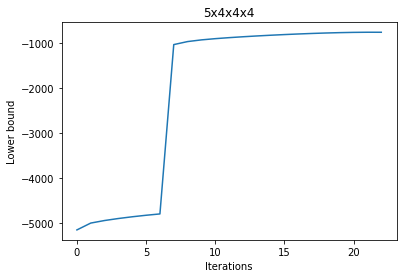

In [459]:
plt.plot(LB)
plt.xlabel('Iterations')
plt.ylabel('Lower bound')
plt.title('5x4x4x4')

Text(0.5, 1.0, '7x7x7')

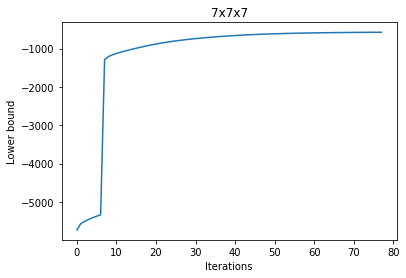

In [10]:
plt.plot(LB)
plt.xlabel('Iterations')
plt.ylabel('Lower bound')
plt.title('7x7x7')

Text(0.5, 1.0, '2x2x2x2x2')

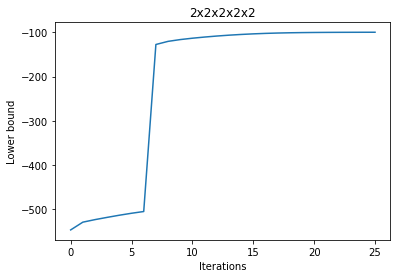

In [476]:
plt.plot(LB)
plt.xlabel('Iterations')
plt.ylabel('Lower bound')
plt.title('2x2x2x2x2')